# 0.0 Modules, etc.

In [ ]:
import numpy as np
import pandas as pd
import multiprocessing
import scipy
import sklearn as sk
from sklearn import svm

from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange
from scipy import spatial
from scipy.spatial import cKDTree
#from pyramid.arima import auto_arima

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
# from bokeh import charts

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random


import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da
#from dask import distributed

# 1 Preprocessing

## 1.1 Wrangling

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

In [ ]:
dat = dat0.copy()

In [ ]:
dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

In [ ]:
dat = dat[dat['gross_demand_quantity'] != 0] 

In [ ]:
dat = dat[['article_number', 'gross_demand_quantity', 'sold_qty',
       'net_qty', 'gross_sales_gross_disc_net_ret',
       'gross_sales_net_disc_gross_ret', 'net_sales', 'total_markdown',
       'temporary_markdown', 'permanent_markdown', 'employee_markdown',
       'fraction_of_full_price', 'markdown', 'sale']]

In [ ]:
dat['sales_price'] = dat['net_sales'].divide(dat['gross_demand_quantity'])

In [ ]:
%%time

dat_grouped = dat.groupby(by = 'article_number')

functions = ['min', 'median', 'mean', 'max', 'std', 'sum', 'count']
dat = dat_grouped.agg(functions)

In [ ]:
dat['Count'] = dat['sold_qty']['count']
dat.drop('count', level = 1, axis = 1, inplace = True) # # Drop redundant 'count' columns

dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
dat = dat.replace([np.inf, -np.inf, np.nan], 0)

## 1.2 Save/Load curated data

In [179]:
# Save/load tidied version

# dat.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

## 1.3 Principal Component Analysis (for 2-D visualizations)

In [ ]:
%%time

# SCALING: zero mean and unit variance 
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(dat)
# dat_scaled = scaler.transform(dat)

# PRINCIPAL COMPONENT ANALYSIS
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # keep the first two principal components of the data
pca.fit(dat)

# transform data onto the first two principal components
dat_pca = pca.transform(dat)

In [ ]:
# EDA 
np.isnan(np.log(dat_pca[:,0])).sum()
(dat_pca[:,1] < 0).sum()
(pd.DataFrame(dat_pca)).describe()

# 2 Classification

## 2.0 Revenue based

In [189]:
dat.head()

gross_demand_quantity                                         \
                                 min median      mean  max       std    sum   
article_number                                                                
001354                             1    1.0  1.592079   27  1.826538   3216   
002214                             1    1.0  1.688105   68  2.690003   6457   
002232                             1    1.0  1.866091  111  3.801818  12751   
002240                             1    1.0  1.256831    9  0.833283   1150   
002267                             1    1.0  1.691641   49  2.419524   5464   

               sold_qty                               ...         sale  \
                    min median      mean  max         ...          max   
article_number                                        ...                
001354                1    1.0  1.580198   27         ...            1   
002214                1    1.0  1.672418   66         ...            1   
002232                1    1.0  1.847066  109         ...            1   
002240                1    1.0  1.251366    9         ...            0   
002267                1    1.0  1.673065   46         ...            1   

                             sales_price                             \
                     std sum         min median       mean      max   
article_number                                                        
001354          0.150789  47       -0.01  47.02  45.051475   69.000   
002214          0.091094  32       -0.01  54.89  52.581970  119.940   
002232          0.085235  50       -0.01  54.89  52.554818   89.550   
002240          0.000000   0       -0.01  56.22  54.016448   89.555   
002267          0.172395  99        0.00  54.45  52.180139   89.555   

                                                       Count  
                      std            sum Unnamed: 85_level_1  
article_number                                                
001354          11.769385   91003.978756                2020  
002214          12.956441  201126.036814                3825  
002232          13.213815  359107.069854                6833  
002240          14.108747   49425.049726                 915  
002267          12.906768  168541.849748                3230  

[5 rows x 85 columns]

In [240]:
total = dat_sales_sorted['net_sales']['sum'].sum()

dat_sales_sorted = dat.sort_values([('net_sales', 'sum')], ascending=False)

dat_sales_sorted['running_total_net_sales'] = dat_sales_sorted['net_sales']['sum'].cumsum()
dat_sales_sorted['running_pct_total_net_sales'] = dat_sales_sorted['net_sales']['sum'].cumsum()/total

t = pd.Series(range(1, 46573))/46572
dat_sales_sorted['running_pct_total_articles'] = t.values

In [242]:
dat_sales_sorted.head()
dat_sales_sorted.shape

gross_demand_quantity                                       \
                                 min median        mean   max         std   
article_number                                                              
CP9366                             1    3.0  255.636364  8181  849.951464   
AH2203                             1    3.0  164.550459  3896  458.114639   
EF2905                             1    2.0  144.089041  2098  394.540237   
EE7287                             1    4.0  130.819277  2381  412.341581   
M20325                             1    1.0    1.686382    94    3.021171   

                       sold_qty                           \
                   sum      min median        mean   max   
article_number                                             
CP9366          202464        1    2.0  245.705808  7916   
AH2203           35872        1    3.0  161.839450  3879   
EF2905           21037        1    2.0  133.472603  1887   
EE7287           21716        1    4.0  124.969880  2276   
M20325           45620        1    1.0    1.673407    93   

                          ...             sales_price                          \
                          ...                     min      median        mean   
article_number            ...                                                   
CP9366                    ...                    0.00  109.291690  118.123204   
AH2203                    ...                   21.43  135.040000  128.082619   
EF2905                    ...                    0.00  102.640000  113.034196   
EE7287                    ...                    0.00   96.347879  111.438988   
M20325                    ...                  -31.39   59.850000   58.021637   

                                                                  Count  \
                       max        std           sum Unnamed: 85_level_1   
article_number                                                            
CP9366          197.925000  31.099666  9.355358e+04                 792   
AH2203          179.706427  28.683589  2.792201e+04                 218   
EF2905          195.846543  27.871254  1.650299e+04                 146   
EE7287          164.280000  32.156830  1.849887e+04                 166   
M20325          119.740000  14.791577  1.569601e+06               27052   

               running_total_net_sales running_pct_total_net_sales  \
                                                                     
article_number                                                       
CP9366                     26557219.38                    0.039186   
AH2203                     32195732.29                    0.047506   
EF2905                     35015863.70                    0.051667   
EE7287                     37672789.39                    0.055587   
M20325                     40173649.19                    0.059278   

               running_pct_total_articles  
                                           
article_number                             
CP9366                           0.000021  
AH2203                           0.000043  
EF2905                           0.000064  
EE7287                           0.000086  
M20325                           0.000107  

[5 rows x 88 columns]

(46572, 88)

Text(0.5, 0, 'Percent of Articles')

Text(0, 0.5, 'Percent of Net Sales')

Text(0.5, 1.0, 'Majority of Sales, from a Minority of Articles')

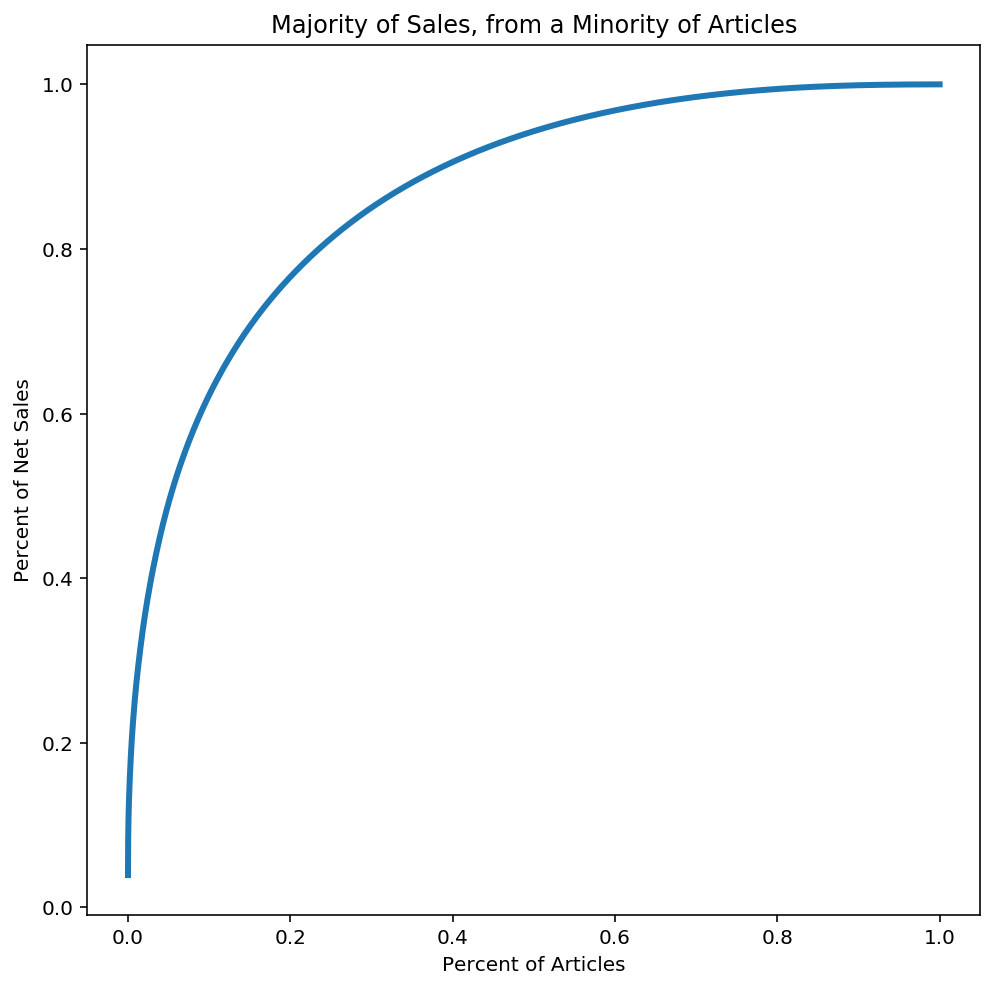

In [252]:
plt.plot(dat_sales_sorted['running_pct_total_articles'], 
         dat_sales_sorted['running_pct_total_net_sales'],
        linewidth = 3)

plt.xlabel('Percent of Articles')
plt.ylabel('Percent of Net Sales')

plt.rcParams["figure.figsize"] = [6,6]
plt.title('Majority of Sales, from a Minority of Articles')

## 2.1 k-means

### 2.1.1 Model

In [ ]:
%%time

# K-means clustering  --------------------  --------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)
kmeans.fit(dat)

Kmeans = pd.Series(kmeans.predict(dat)) # Cluster assignments

In [ ]:
# Reclassify: majority/non as 0/1 

Kmeans.value_counts()

In [ ]:
Kmeans = (Kmeans != 0)*1 # lone vector
Kmeans.value_counts()

In [253]:
dat['Kmeans'] = Kmeans.values
dat.head()

gross_demand_quantity                                         \
                                 min median      mean  max       std    sum   
article_number                                                                
001354                             1    1.0  1.592079   27  1.826538   3216   
002214                             1    1.0  1.688105   68  2.690003   6457   
002232                             1    1.0  1.866091  111  3.801818  12751   
002240                             1    1.0  1.256831    9  0.833283   1150   
002267                             1    1.0  1.691641   49  2.419524   5464   

               sold_qty                        ...        sale      \
                    min median      mean  max  ...         std sum   
article_number                                 ...                   
001354                1    1.0  1.580198   27  ...    0.150789  47   
002214                1    1.0  1.672418   66  ...    0.091094  32   
002232                1    1.0  1.847066  109  ...    0.085235  50   
002240                1    1.0  1.251366    9  ...    0.000000   0   
002267                1    1.0  1.673065   46  ...    0.172395  99   

               sales_price                                        \
                       min median       mean      max        std   
article_number                                                     
001354               -0.01  47.02  45.051475   69.000  11.769385   
002214               -0.01  54.89  52.581970  119.940  12.956441   
002232               -0.01  54.89  52.554818   89.550  13.213815   
002240               -0.01  56.22  54.016448   89.555  14.108747   
002267                0.00  54.45  52.180139   89.555  12.906768   

                                            Count Kmeans  
                          sum Unnamed: 85_level_1         
article_number                                            
001354           91003.978756                2020      1  
002214          201126.036814                3825      1  
002232          359107.069854                6833      1  
002240           49425.049726                 915      1  
002267          168541.849748                3230      1  

[5 rows x 86 columns]

### 2.1.2 Plots

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

Text(0.5, 0, 'Sales Price')

Text(0, 0.5, 'log(sold_qty)')

Text(0.5, 1.0, 'K-means Classification')

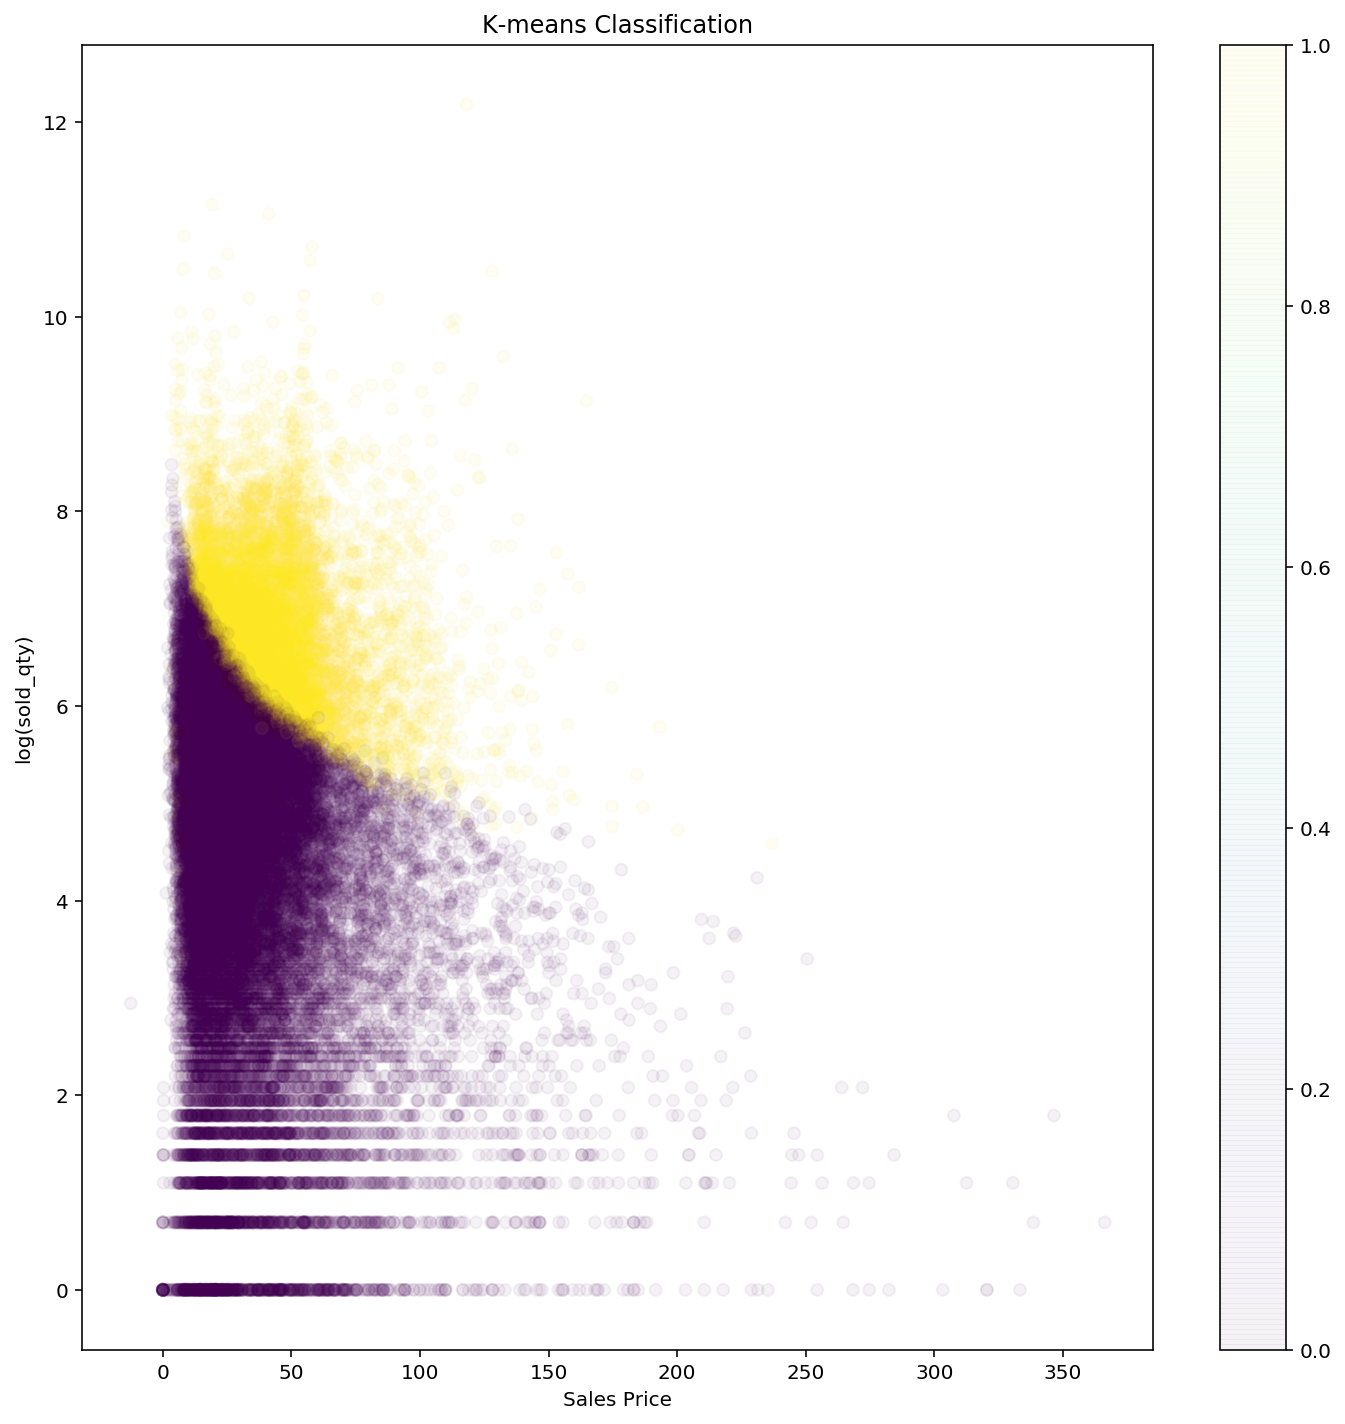

In [270]:
# plt.scatter(dat_pca[:,0], 
#             dat_pca[:,1], 
#             c = Kmeans,
#             alpha = 0.05)

# plt.xlabel('PC1')
# plt.ylabel('PC2')

# plt.xscale('symlog')
# plt.yscale('symlog')

plt.scatter(dat['sales_price']['mean'], 
            np.log(dat['sold_qty']['sum']), 
            c = Kmeans,
            alpha = 0.05)

plt.xlabel('Sales Price')
plt.ylabel('log(sold_qty)')

plt.colorbar()
plt.rcParams["figure.figsize"] = [12,12]
plt.title('K-means Classification')



### 2.1.3 Histograms

Text(0.5, 0, 'Total Gross Demand Quantity')

Text(0, 0.5, 'Quantity')

Text(0.5, 1.0, 'Basic Articles')

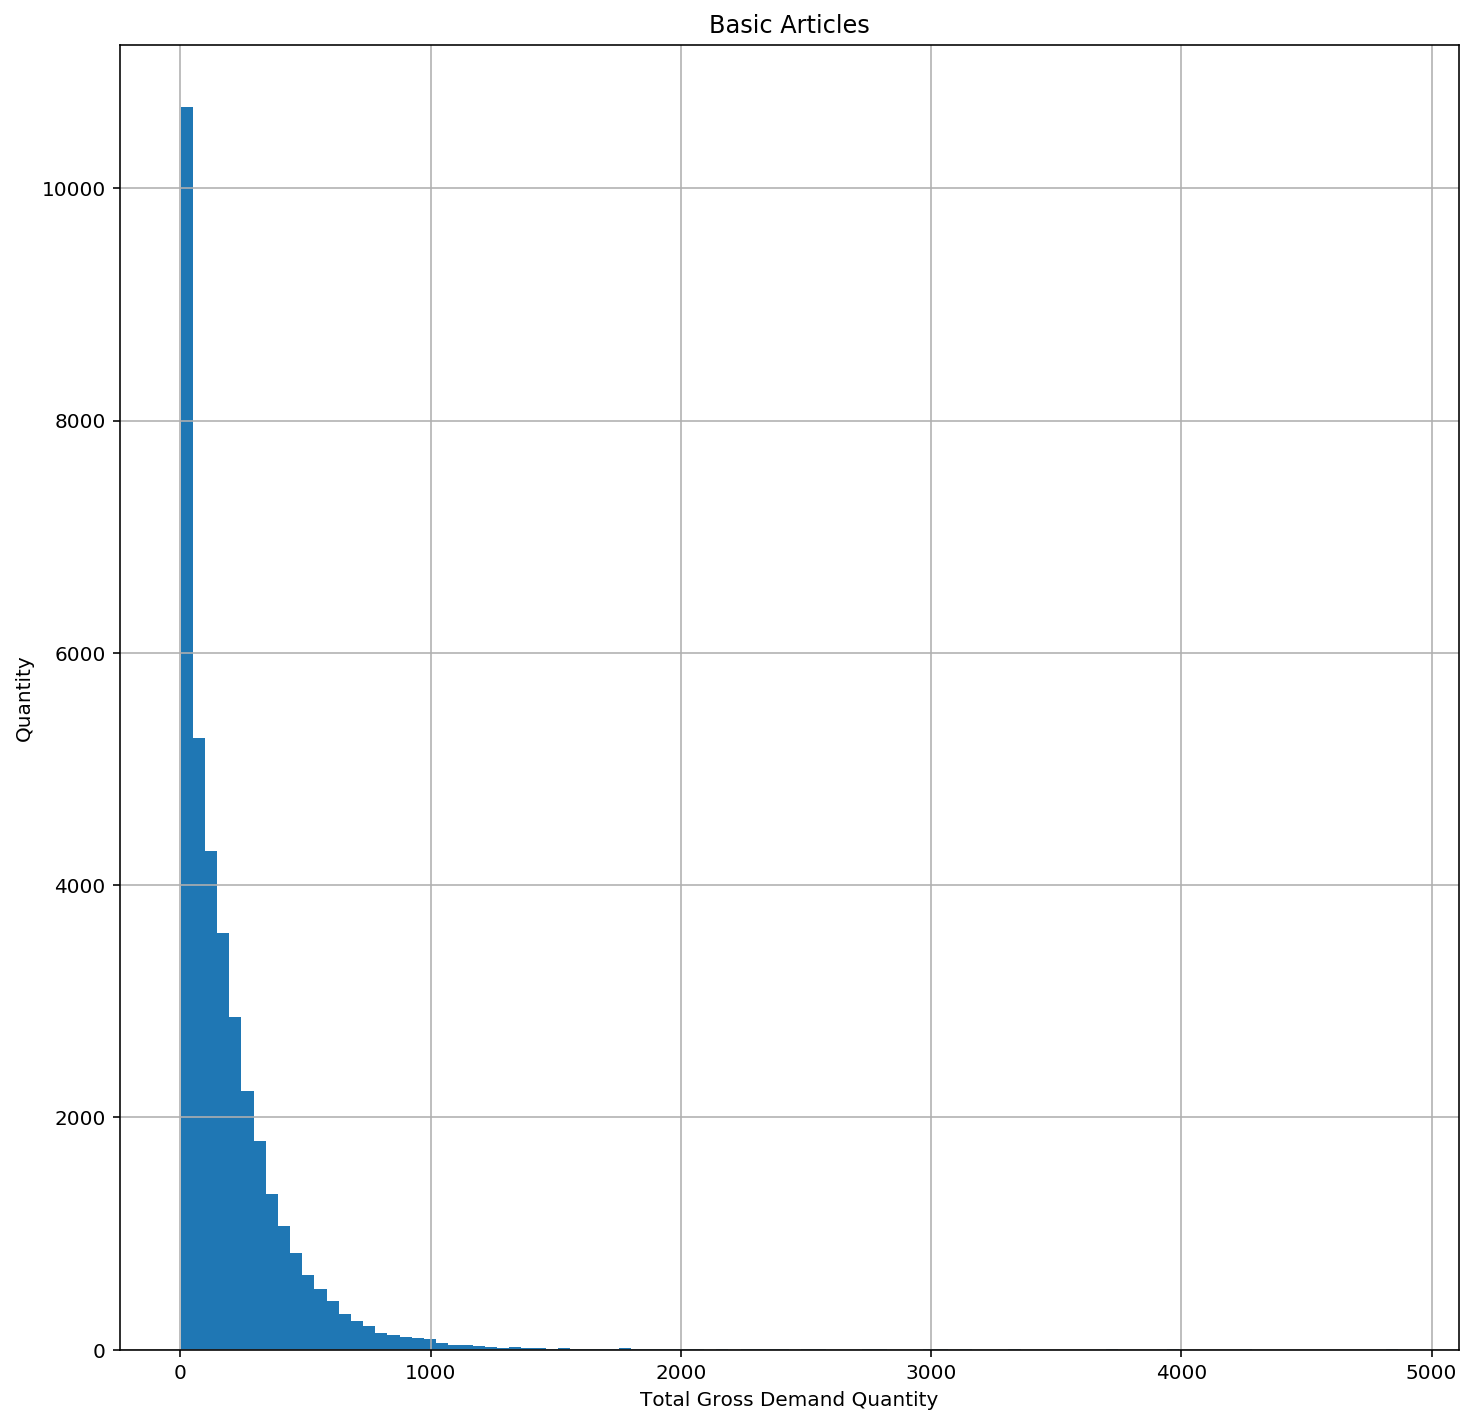

In [272]:
# Histogram: total gross demand quantity, basic items
dat[(dat['Kmeans'] == 0) & (dat['gross_demand_quantity']['sum'] < 10000)]['gross_demand_quantity']['sum'].hist(
    bins = 100, 
)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')

Text(0.5, 0, 'Total Gross Demand Quantity')

Text(0, 0.5, 'Quantity')

Text(0.5, 1.0, 'Non-basic Articles')

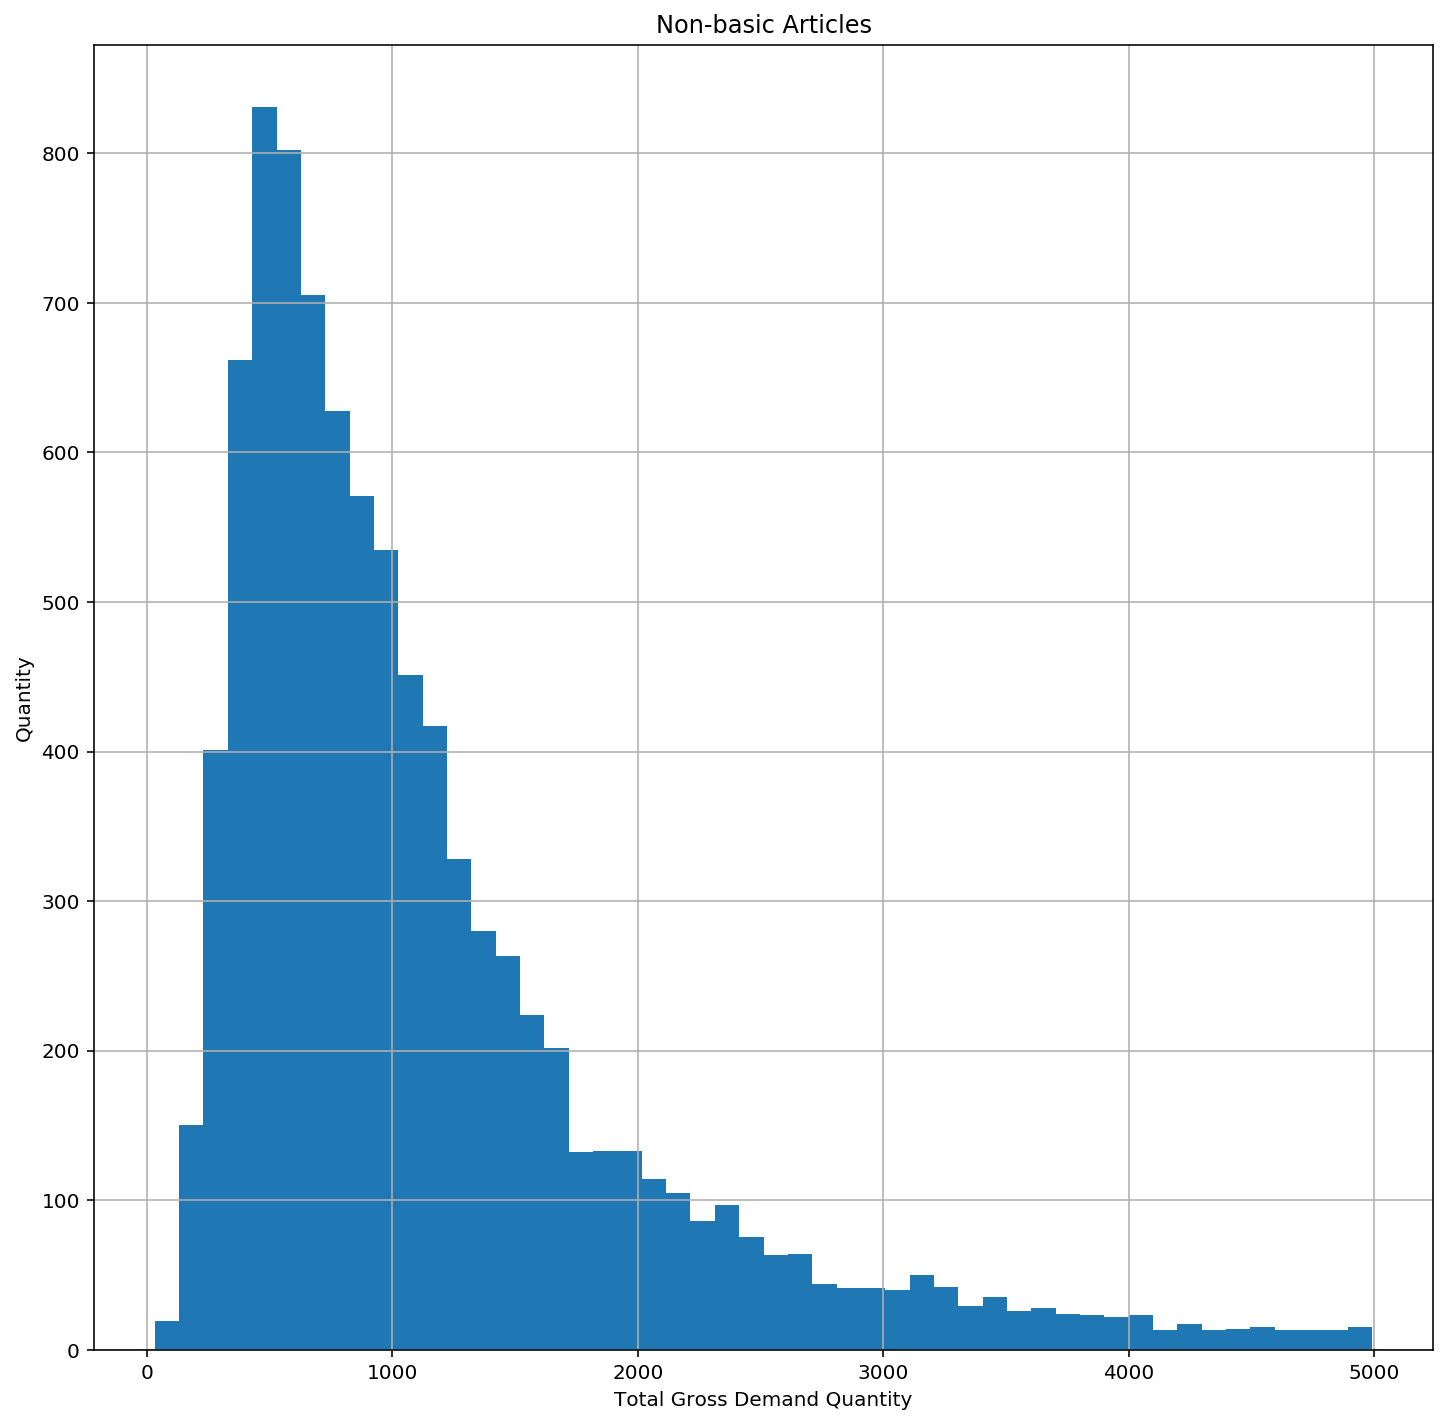

In [273]:
# Histogram: total gross_demand_quantity, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['gross_demand_quantity']['sum'] < 5000)]['gross_demand_quantity']['sum'].hist(bins = 50)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')


Text(0.5, 0, 'Sale Price')

Text(0, 0.5, 'Quantity')

Text(0.5, 1.0, 'Basic Articles')

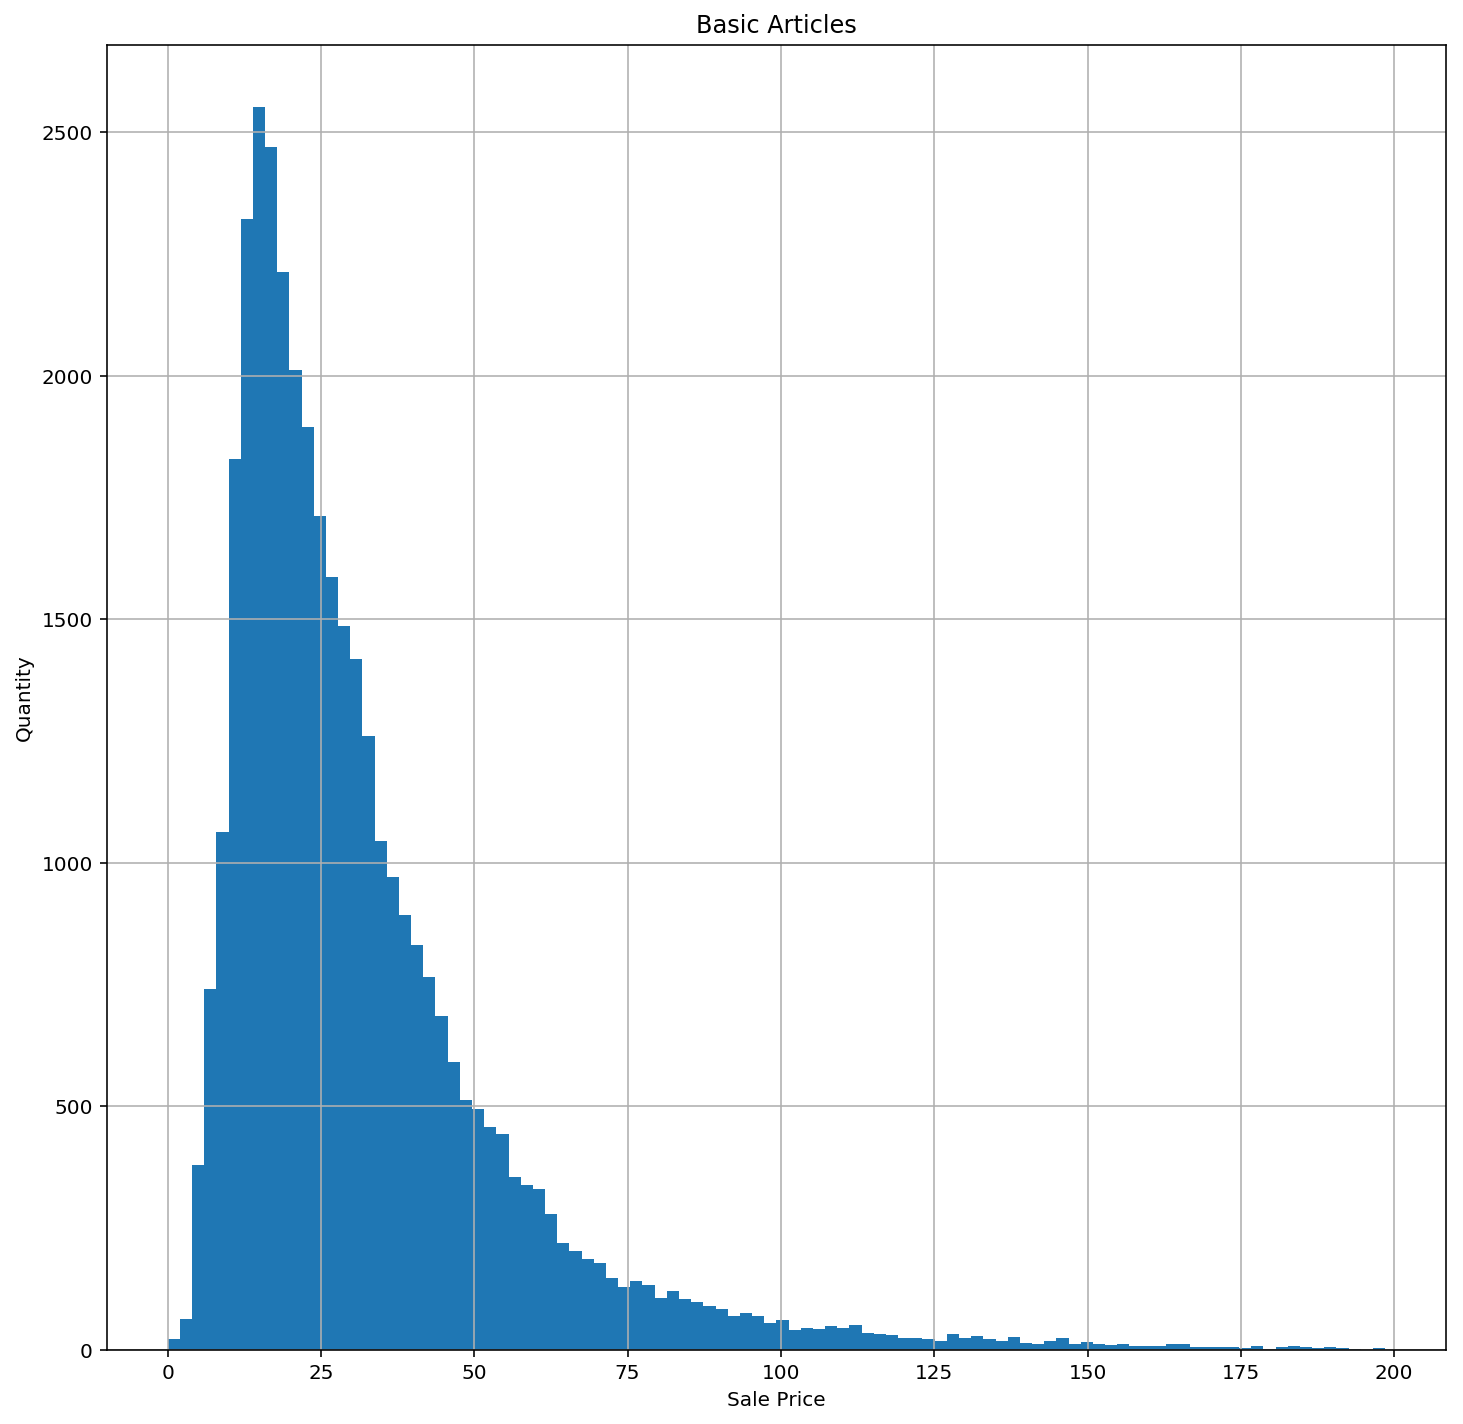

In [277]:
# Histogram: sales_price, basic items
dat[(dat['Kmeans'] == 0) & (dat['sales_price']['mean'] < 200) & (dat['sales_price']['mean'] > 0)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')


Text(0.5, 0, 'Sale Price')

Text(0, 0.5, 'Quantity')

Text(0.5, 1.0, 'Non-basic Articles')

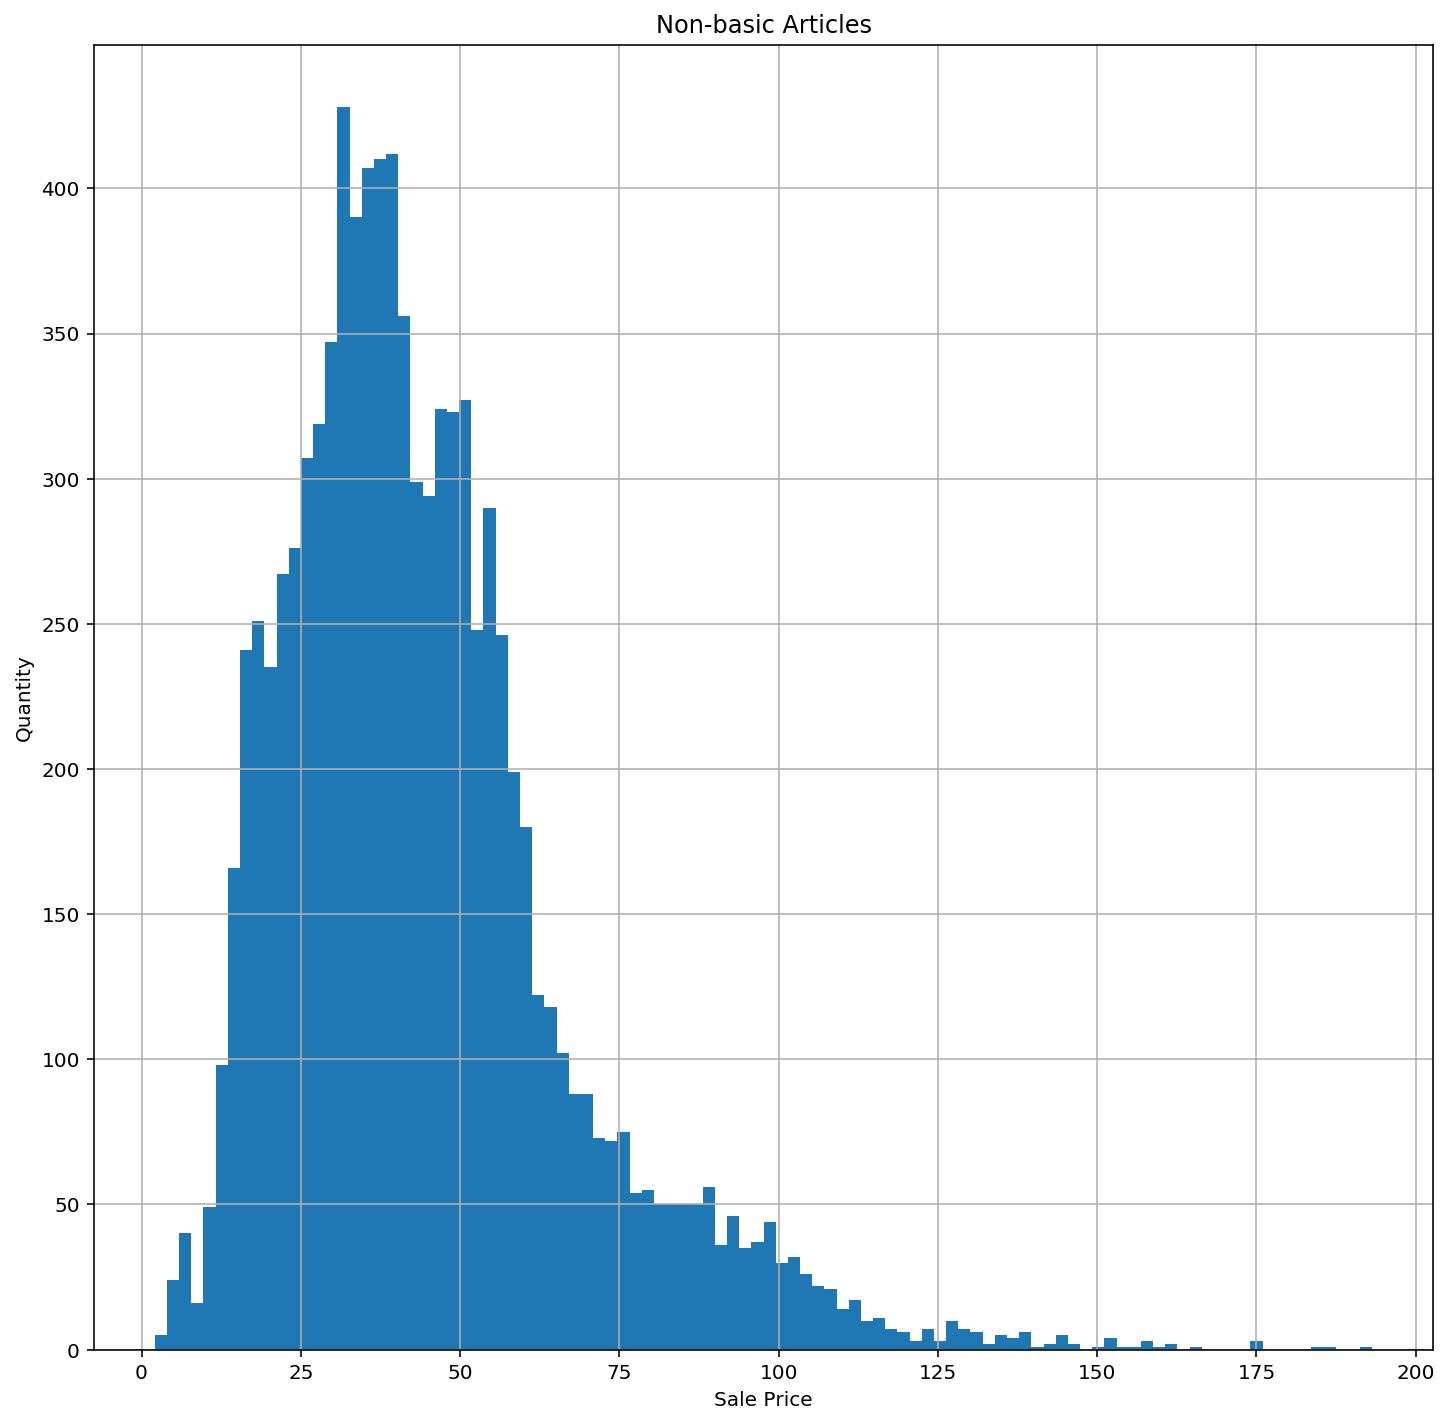

In [276]:
# Histogram: sales_price, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['sales_price']['mean'] < 200)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')

## 2.2 Agglomerative Clustering

### 2.2.1 Model

In [186]:
%%time

# Agglomerative Clustering -------------
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 10)
agglom = pd.Series(agg.fit_predict(dat))

CPU times: user 5min 42s, sys: 2min 18s, total: 8min
Wall time: 12min 26s


In [ ]:
# # Reclassify: majority/non as 0/1 

agglom.value_counts()
agglom = (agglom != 1)*1 # lone vector
agglom.value_counts()

### 2.2.2 Plot

In [ ]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = agglom,
            alpha = 0.15)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
plt.title('Agglomerative Classification')

## 2.3 DBSCAN - 'density based spatial clustering of applications with noise'

In [ ]:
%%time

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dat)
dat_scaled = scaler.transform(dat)

In [181]:
%%time

from sklearn.cluster import DBSCAN

dbscan = DBSCAN() # 3min 36s
dbs = pd.Series(dbscan.fit_predict(dat_scaled))

CPU times: user 3min 35s, sys: 648 ms, total: 3min 36s
Wall time: 3min 36s


In [ ]:
dbs.value_counts()

In [184]:
# # Reclassify: majority/non as 0/1 
dbs01 = (dbs != -1)*1 # lone vector
dbs01.value_counts()

0    37169
1     9403
dtype: int64

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log(net_sales)')

Text(0, 0.5, 'log(sold_qty)')

Text(0.5, 1.0, 'DBSCAN Classification')

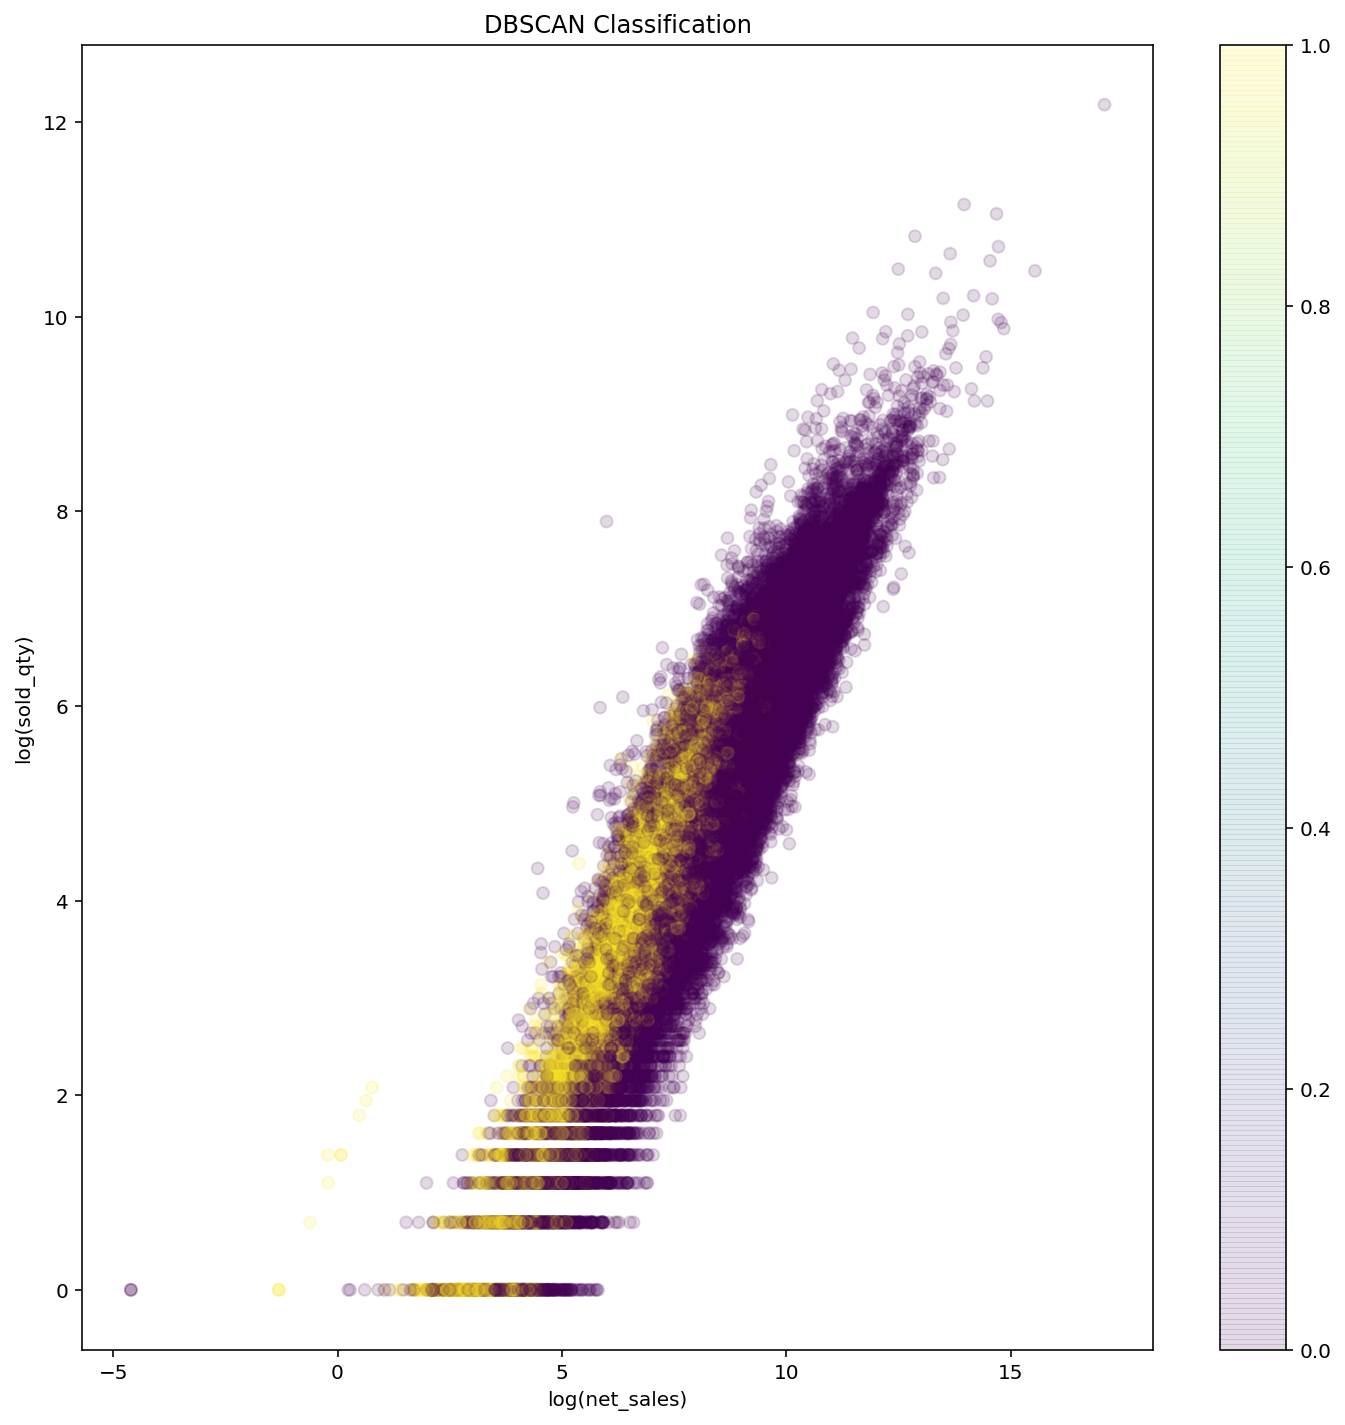

In [185]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dbs01,
            alpha = 0.15)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
plt.title('DBSCAN Classification')
plt.rcParams["figure.figsize"] = [16,16]

## 2.4 Cross-method comparisons

   ### 2.4.1 K-means x Agglomerative

In [ ]:
table = pd.DataFrame(data = {'Ag': agglom, 'Km': Kmeans, 'DB': dbs01})
table.groupby(['Ag', 'Km', 'DB']).size()
# 3924/46573 # disagreement

# table[(table['Ag'] == 0) & (table['Km'] == 1)]

# 3 Article Reference Data

## 3.1 Import, Process

In [ ]:
# Key 1 = article number <----> group article

In [ ]:
# 'article_descr'

In [ ]:
# dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

In [ ]:
dat2 = pd.read_csv('article_reference_data_y2016_18.csv',
                 delimiter = '~',
                  low_memory = False,
                   usecols=['group_article', 'brand', 'sub_brand', 'season_create', 'season_active',
                            'graphic', 'gender', 'age_group', 'retail_intro_date_global',
                            'retail_exit_date_global', 'material_technology', 'pictogram_composition',
                            'price_band', 'gender_age', 'construction_type', 'length_mes_uom_dim',
                            'uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim', 'article_descr',
                            'drop_season', 'uom_vol', 'uom_wgt', 'product_fit', 'material_way_type',
                            'outer_sole_main_material', 'inner_sole_main_material', 'main_material_lining',
                            'main_material_upper', 'dimension_uov', 'dimension_uom', 'carried_over_from',
                            'drop_date', 'retail_exit_tgt_season', 'product_franchise', 'age_group_descr',
                            'brand_descr', 'sub_brand_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr',
                            'rmh_retail_class_descr', 'rmh_retail_department_descr', 'rmh_retail_sub_class_descr',
                            'rmh_retail_sub_dept_descr', 'rmh_category_descr', 'rmh_gender_descr',
                            'rmh_retail_section_descr', 'rmh_product_division_descr', 'rmh_product_type_descr',
                            'spm_color_first_descr', 'spm_color_second_descr', 'spm_color_third_descr',
                            'spm_color_fourth_descr', 'product_franchise_descr'
                           ]
                  )

In [ ]:
dat2 = dat2[['group_article', 'article_descr']]
dat2.head()

In [ ]:
dat = dat[['Kmeans']]
dat['article'] = dat.index

In [ ]:
dat3 = pd.merge(dat, dat2, left_on= 'article', right_on= 'group_article')
dat3.columns = ('Kmeans', 'article', 'article2', 'descr')

In [ ]:
dat3[dat3['Kmeans'] == 0]['descr'].value_counts()

In [ ]:
# Cluster Prediction